#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Необходимо:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

__Цель исследования:__
* Построить модель, которая сможет спрогнозировать количество заказов такси на следующий час.

__Ход исследования:__
* Провести обработку данных.
* Проанализировать имеющиеся данные, выявив наличие трендов, сезонности. Проверить данные на стационарность.
* Построить и обучить модели, выделив лучшую.
* Проверить лучшую модель на тестовых данных.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score

## Подготовка

### Обзор данных

In [2]:
try:
    df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', parse_dates=[0], index_col=[0])
df.sort_index(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [5]:
df.isna().sum()

num_orders    0
dtype: int64

### Сортировка и ресамплирование

In [6]:
df = df.sort_index()
df.index.is_monotonic

True

In [7]:
df = df.resample('1H').sum()

In [8]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


 __Вывод:__ Получены данные по заказу такси. Пропусков в данных нет. В качестве индекса для удобства исследования был принят первый столбец - время заказа. Данные были проверены на монотонность и ресамплированы по часу.

## Анализ

Выведем наши данные в форме графика

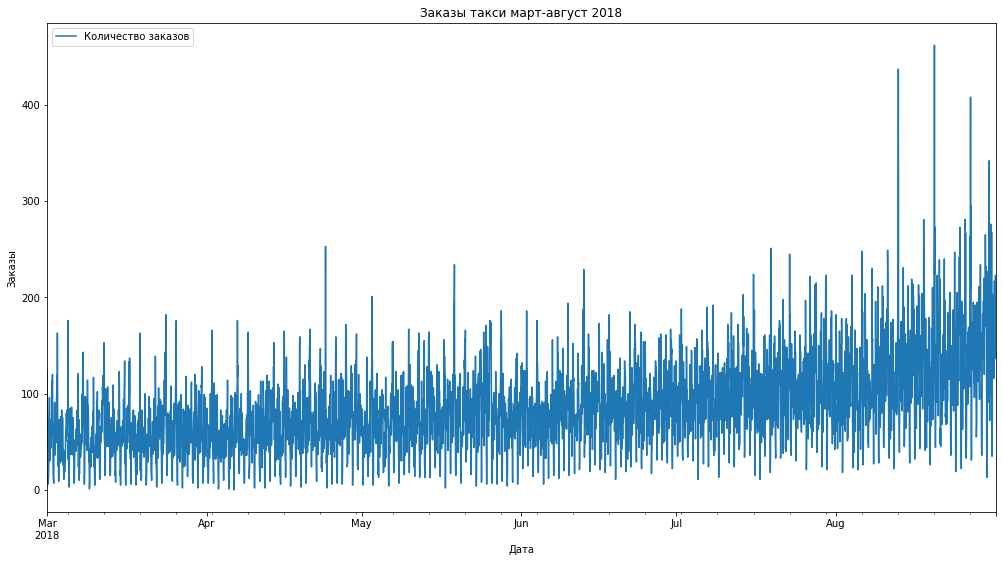

In [9]:
df.plot(figsize=(17,9))
plt.xlabel('Дата')
plt.ylabel('Заказы')
plt.title('Заказы такси март-август 2018')
plt.legend(['Количество заказов'])
plt.show()

Рассмотрим более краткий промежуток времени

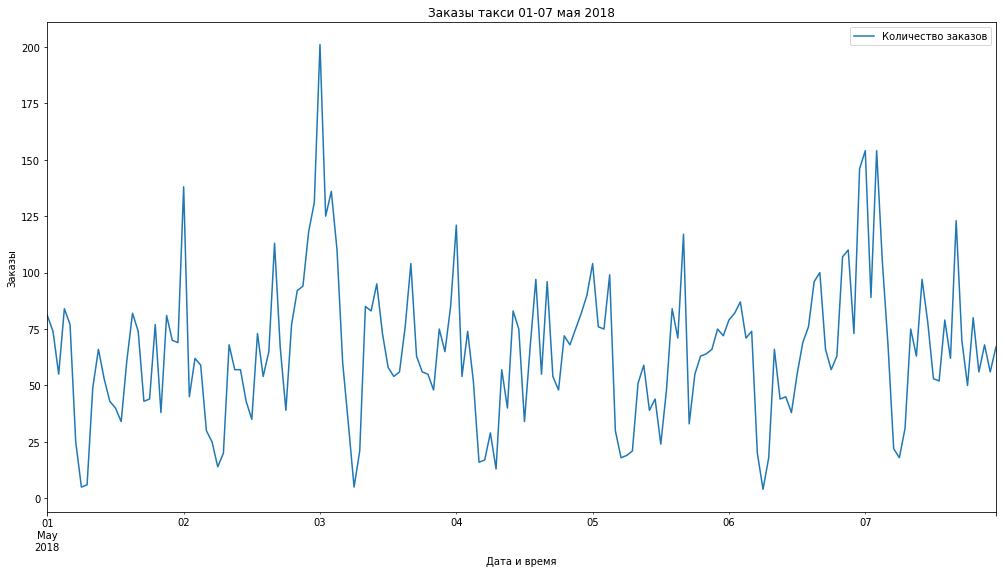

In [10]:
df['2018-05-01':'2018-05-07'].plot(figsize=(17,9))
plt.xlabel('Дата и время')
plt.ylabel('Заказы')
plt.title('Заказы такси 01-07 мая 2018')
plt.legend(['Количество заказов'])
plt.show()

Посмотрим на тренды и сезонность.

In [11]:
decomposed_df = seasonal_decompose(df)

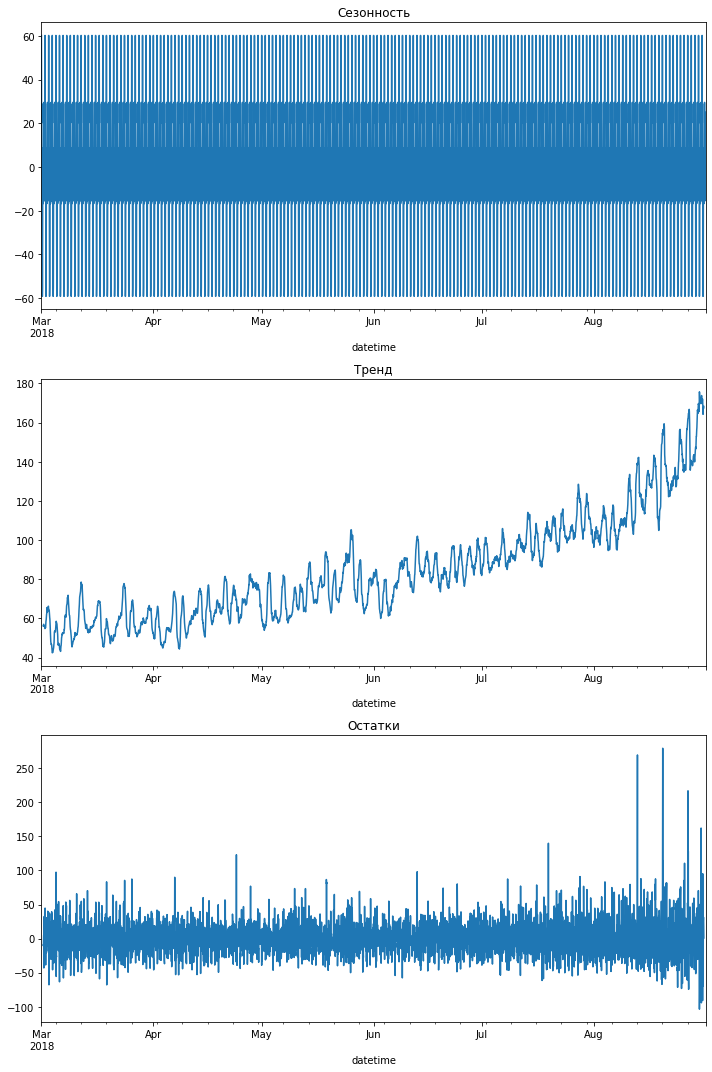

In [12]:
plt.figure(figsize=(10, 15))
plt.subplot(311)
decomposed_df.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(312)
decomposed_df.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(313)
decomposed_df.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()

Проверим сезонность и тренды за последнюю неделю

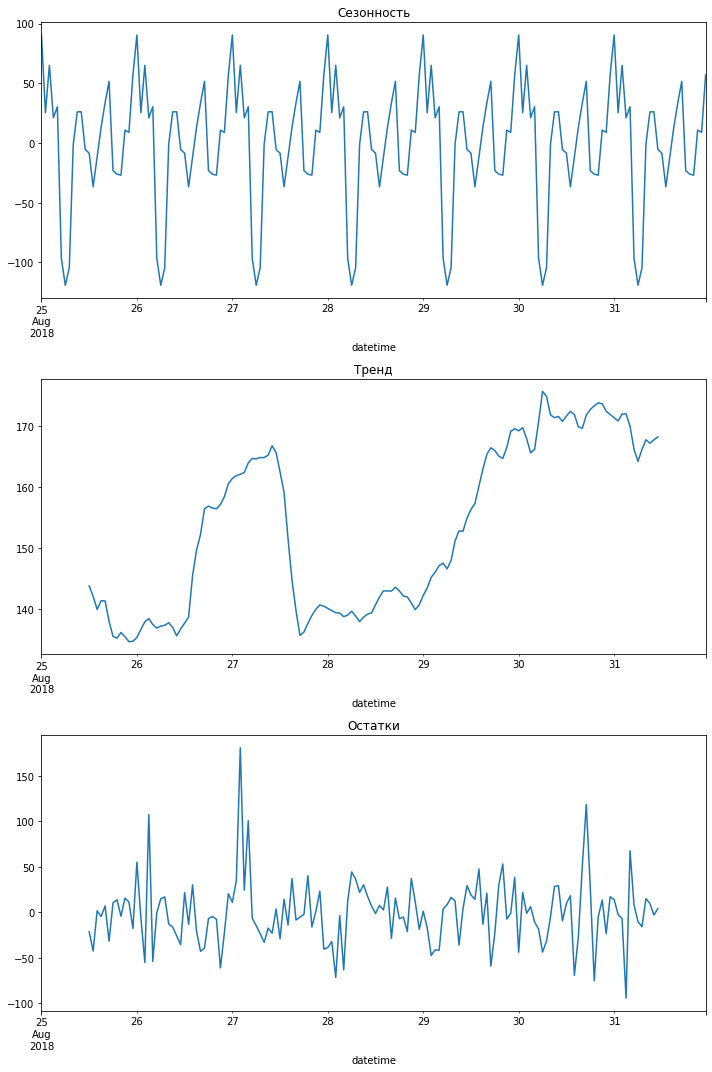

In [13]:
decomposed_df_week = seasonal_decompose(df['2018-08-25':'2018-08-31'])

plt.figure(figsize=(10, 15))
plt.subplot(311)
decomposed_df_week.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(312)
decomposed_df_week.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(313)
decomposed_df_week.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()

И посмотрим на тренд за июль-август.

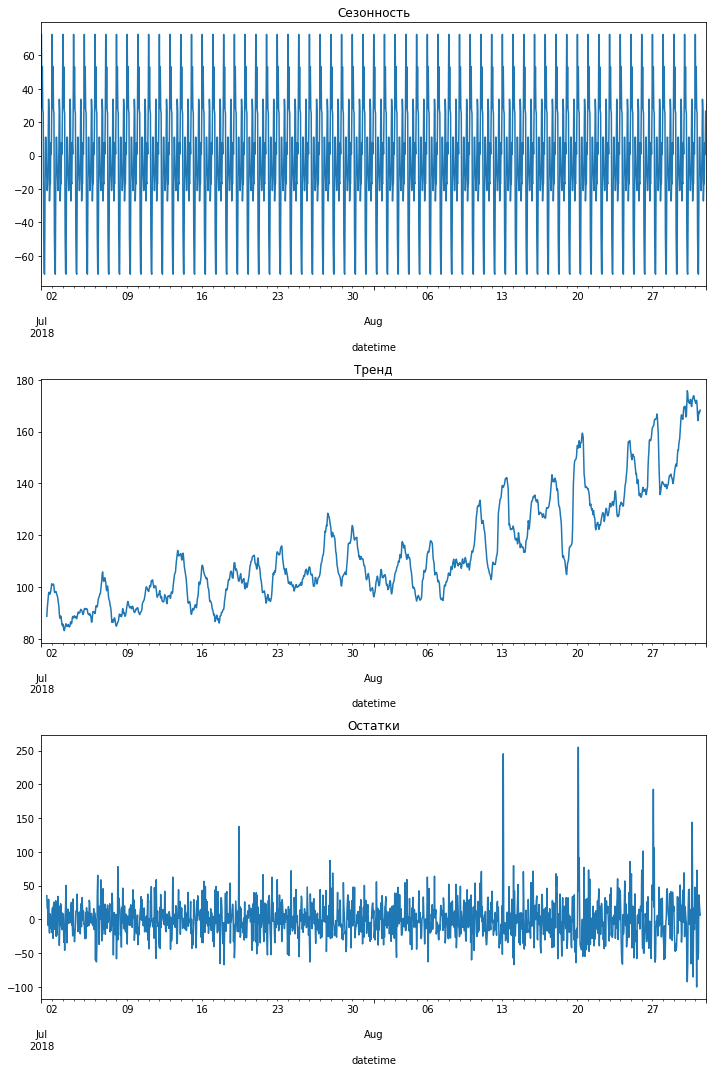

In [14]:
decomposed_df_ja = seasonal_decompose(df['2018-07-01':'2018-08-31'])

plt.figure(figsize=(10, 15))
plt.subplot(311)
decomposed_df_ja.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(312)
decomposed_df_ja.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(313)
decomposed_df_ja.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()

Виден тренд на увеличение заказов со временем.

Посмотрим на сезонность в пару конкретных дней.

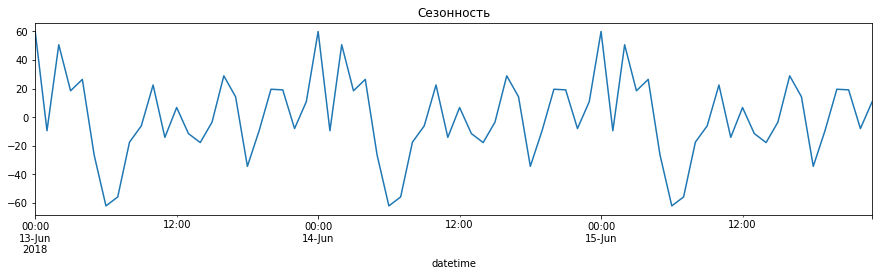

In [15]:
decomposed_df_days = seasonal_decompose(df['2018-06-13':'2018-06-15'])

plt.figure(figsize=(15, 12))
plt.subplot(311)
decomposed_df_days.seasonal.plot(ax=plt.gca())
plt.title('Сезонность');

Видно, что больше всего заказов приходится на 12 ночи, а меньше всего - на 6 утра.

Проверим страционарность временного ряда.

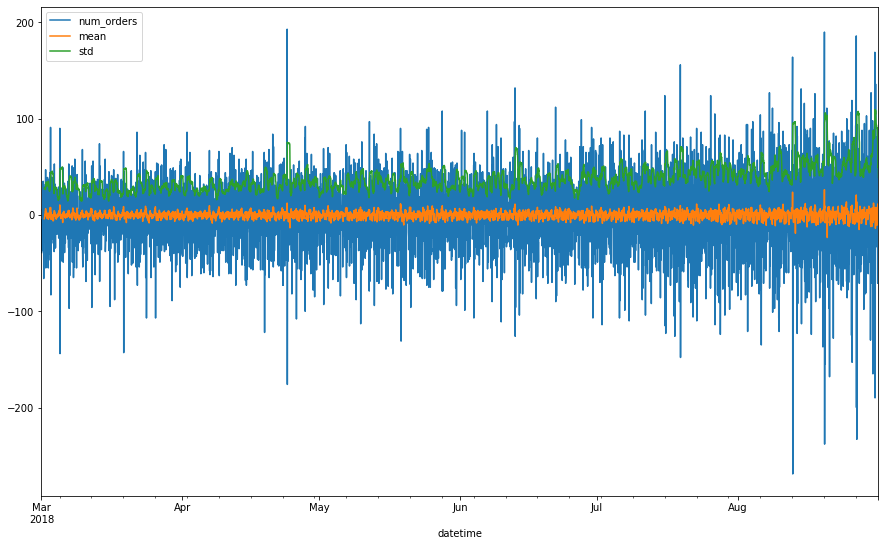

In [16]:
df_shifted = df - df.shift()
df_shifted['mean'] = df_shifted['num_orders'].rolling(15).mean()
df_shifted['std'] = df_shifted['num_orders'].rolling(15).std()
df_shifted.plot(figsize=(15,9))
plt.show()

Ряд довольно стационарен, поскольку сильные изменения в среднем значении и стандартном отклонении отсутствуют.

Проведем тест Дики-Фуллера:

Нулевая гипотеза: временной ряд нестационарен. Альтернативная: временной ряд стационарен.

In [17]:
result = adfuller(df['num_orders'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical values:')
for key, value in result[4].items():
  print('\t {}: {}'.format(key, value))

ADF Statistic: -3.0689242890279558
p-value: 0.028940051402612906
Critical values:
	 1%: -3.431842162413052
	 5%: -2.8621993540813637
	 10%: -2.567120978470452


Поскольку p-value меньше порогового значения 0.05, нулевую гипотезу можно отвергнуть.

Для задач исследования создадим признаки:

In [18]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag) 
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [19]:
make_features(df, 24, 10)
df.head(10)

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,1,3,5,43.0,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,1,3,6,6.0,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,1,3,7,12.0,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,1,3,8,15.0,12.0,6.0,43.0,66.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Очистим полученную таблицу от пропусков.

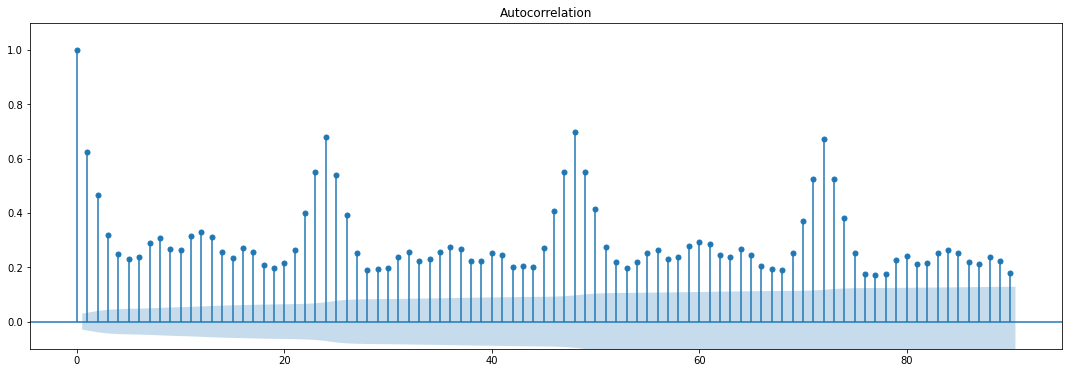

In [20]:
# Код ревьюера
from statsmodels.graphics import tsaplots

fig = tsaplots.plot_acf(df['num_orders'],lags= 90)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 

In [21]:
df.dropna(inplace=True)
df.head(10)

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,2,4,0,58.0,113.0,66.0,61.0,45.0,73.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,61.7
2018-03-02 01:00:00,120,2,4,1,90.0,58.0,113.0,66.0,61.0,45.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,65.9
2018-03-02 02:00:00,75,2,4,2,120.0,90.0,58.0,113.0,66.0,61.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,71.3
2018-03-02 03:00:00,64,2,4,3,75.0,120.0,90.0,58.0,113.0,66.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,74.5
2018-03-02 04:00:00,20,2,4,4,64.0,75.0,120.0,90.0,58.0,113.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,76.5
2018-03-02 05:00:00,11,2,4,5,20.0,64.0,75.0,120.0,90.0,58.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,71.2
2018-03-02 06:00:00,11,2,4,6,11.0,20.0,64.0,75.0,120.0,90.0,...,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,67.8
2018-03-02 07:00:00,7,2,4,7,11.0,11.0,20.0,64.0,75.0,120.0,...,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,62.8
2018-03-02 08:00:00,46,2,4,8,7.0,11.0,11.0,20.0,64.0,75.0,...,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,56.9


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4392 non-null   int64  
 1   day           4392 non-null   int64  
 2   dayofweek     4392 non-null   int64  
 3   hour          4392 non-null   int64  
 4   lag_1         4392 non-null   float64
 5   lag_2         4392 non-null   float64
 6   lag_3         4392 non-null   float64
 7   lag_4         4392 non-null   float64
 8   lag_5         4392 non-null   float64
 9   lag_6         4392 non-null   float64
 10  lag_7         4392 non-null   float64
 11  lag_8         4392 non-null   float64
 12  lag_9         4392 non-null   float64
 13  lag_10        4392 non-null   float64
 14  lag_11        4392 non-null   float64
 15  lag_12        4392 non-null   float64
 16  lag_13        4392 non-null   float64
 17  lag_14        4392 non-null

__Вывод:__ Были проанализированны графики временного ряда. Как по всем данным, так и по нескольким месяцам и нескольким дням.

Выявился тренд на увеличение количества заказов. Также проявилась сезонность - максимум заказов приходится на 12 ночи, а минимум - на 6 утра. 

Была продтверждена стационарность временного ряда.

Для задач исследования были добавлены признаки часа, дня и дня недели. После удаления пропусков, была получена таблица с данными, достаточными для построения моделей.

## Обучение

Разделим данные на обучающую и тестовые выборки.

In [23]:
df_train, df_test = train_test_split(df, shuffle=False, test_size=0.1)

features_train = df_train.drop(['num_orders'], axis=1)
target_train = df_train['num_orders']
 
features_test = df_test.drop(['num_orders'], axis=1)
target_test = df_test['num_orders']

display(df_train.shape)
display(df_test.shape)

display(df_train.index.min(), df_train.index.max(), df_test.index.min(), df_test.index.max())

(3952, 29)

(440, 29)

Timestamp('2018-03-02 00:00:00', freq='H')

Timestamp('2018-08-13 15:00:00', freq='H')

Timestamp('2018-08-13 16:00:00', freq='H')

Timestamp('2018-08-31 23:00:00', freq='H')

### Линейная регрессия

In [24]:
model = LinearRegression()
model.fit(features_train, target_train)

tscv = TimeSeriesSplit(n_splits=10)
scores = cross_val_score(estimator=model, cv=tscv, X=features_train, y=target_train, scoring='neg_root_mean_squared_error')
-np.average(scores)


26.50210762897874

### Модель решающего дерева

In [25]:
%%time

model = DecisionTreeRegressor(random_state=12345)
param_grid = {'max_depth': [n for n in range(1, 21, 1)]}

tuning_model=GridSearchCV(model, param_grid, scoring='neg_root_mean_squared_error', cv=tscv, verbose=3)

tuning_model.fit(features_train, target_train)
display(tuning_model.best_params_)
display(tuning_model.best_score_*-1)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV 1/10] END ...................................max_depth=1; total time=   0.1s
[CV 2/10] END ...................................max_depth=1; total time=   0.0s
[CV 3/10] END ...................................max_depth=1; total time=   0.0s
[CV 4/10] END ...................................max_depth=1; total time=   0.0s
[CV 5/10] END ...................................max_depth=1; total time=   0.0s
[CV 6/10] END ...................................max_depth=1; total time=   0.0s
[CV 7/10] END ...................................max_depth=1; total time=   0.0s
[CV 8/10] END ...................................max_depth=1; total time=   0.0s
[CV 9/10] END ...................................max_depth=1; total time=   0.0s
[CV 10/10] END ..................................max_depth=1; total time=   0.0s
[CV 1/10] END ...................................max_depth=2; total time=   0.0s
[CV 2/10] END ................................

{'max_depth': 5}

28.006624916139778

CPU times: user 6.73 s, sys: 120 ms, total: 6.85 s
Wall time: 7 s


### Модель случайного леса

In [26]:
%%time

model = RandomForestRegressor(random_state=12345)
param_grid = {'max_depth': [5], 'n_estimators': [100, 250, 500]}

tuning_model=GridSearchCV(model, param_grid, scoring='neg_root_mean_squared_error', cv=tscv, verbose=3)

tuning_model.fit(features_train, target_train)
display(tuning_model.best_params_)
display(tuning_model.best_score_*-1)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV 1/10] END .................max_depth=5, n_estimators=100; total time=   0.3s
[CV 2/10] END .................max_depth=5, n_estimators=100; total time=   0.5s
[CV 3/10] END .................max_depth=5, n_estimators=100; total time=   0.7s
[CV 4/10] END .................max_depth=5, n_estimators=100; total time=   0.9s
[CV 5/10] END .................max_depth=5, n_estimators=100; total time=   1.0s
[CV 6/10] END .................max_depth=5, n_estimators=100; total time=   1.2s
[CV 7/10] END .................max_depth=5, n_estimators=100; total time=   1.4s
[CV 8/10] END .................max_depth=5, n_estimators=100; total time=   1.5s
[CV 9/10] END .................max_depth=5, n_estimators=100; total time=   1.7s
[CV 10/10] END ................max_depth=5, n_estimators=100; total time=   1.8s
[CV 1/10] END .................max_depth=5, n_estimators=250; total time=   0.7s
[CV 2/10] END .................max_depth=5, n_es

{'max_depth': 5, 'n_estimators': 250}

25.703119718506212

CPU times: user 1min 35s, sys: 484 ms, total: 1min 35s
Wall time: 1min 36s


### LightGBM

In [27]:
%%time

model = lgb.LGBMRegressor(random_state=12345)

param_grid = {'num_leaves': [n for n in range(20, 100, 20)], 'learning_rate':[0.1, 0.3, 0.5]}

tuning_model = GridSearchCV(model, param_grid, scoring='neg_root_mean_squared_error', cv=tscv, verbose=3)

tuning_model.fit(features_train, target_train)
display(tuning_model.best_params_)
display(tuning_model.best_score_*-1)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV 1/10] END ..............learning_rate=0.1, num_leaves=20; total time=   4.8s
[CV 2/10] END ..............learning_rate=0.1, num_leaves=20; total time=   4.6s
[CV 3/10] END ..............learning_rate=0.1, num_leaves=20; total time=  37.7s
[CV 4/10] END ..............learning_rate=0.1, num_leaves=20; total time=  21.0s
[CV 5/10] END ..............learning_rate=0.1, num_leaves=20; total time=   1.0s
[CV 6/10] END ..............learning_rate=0.1, num_leaves=20; total time=   0.7s
[CV 7/10] END ..............learning_rate=0.1, num_leaves=20; total time=   0.9s
[CV 8/10] END ..............learning_rate=0.1, num_leaves=20; total time=   0.9s
[CV 9/10] END ..............learning_rate=0.1, num_leaves=20; total time=   1.1s
[CV 10/10] END .............learning_rate=0.1, num_leaves=20; total time=   1.3s
[CV 1/10] END ..............learning_rate=0.1, num_leaves=40; total time=   0.4s
[CV 2/10] END ..............learning_rate=0.1,

{'learning_rate': 0.1, 'num_leaves': 40}

24.1743499113414

CPU times: user 20min 42s, sys: 10.1 s, total: 20min 52s
Wall time: 21min 3s


__Вывод:__ Данные были разделены на обучающую и тестовую выборки. Было обучено четыре модели: линейной регрессии, решающего дерева, случайного леса и LightGBM. Наилучшее значение метрики RMSE оказалось у LightGBM.

## Тестирование

In [28]:
model = lgb.LGBMRegressor(learning_rate=0.1, num_leaves=40, random_state=12345)
model.fit(features_train, target_train)

target_predict = model.predict(features_test)

rmse_LGBMR = mean_squared_error(target_test, target_predict) ** 0.5
display(rmse_LGBMR)

40.784615835741135

Сравним полученные данные предсказаний с оригинальными:

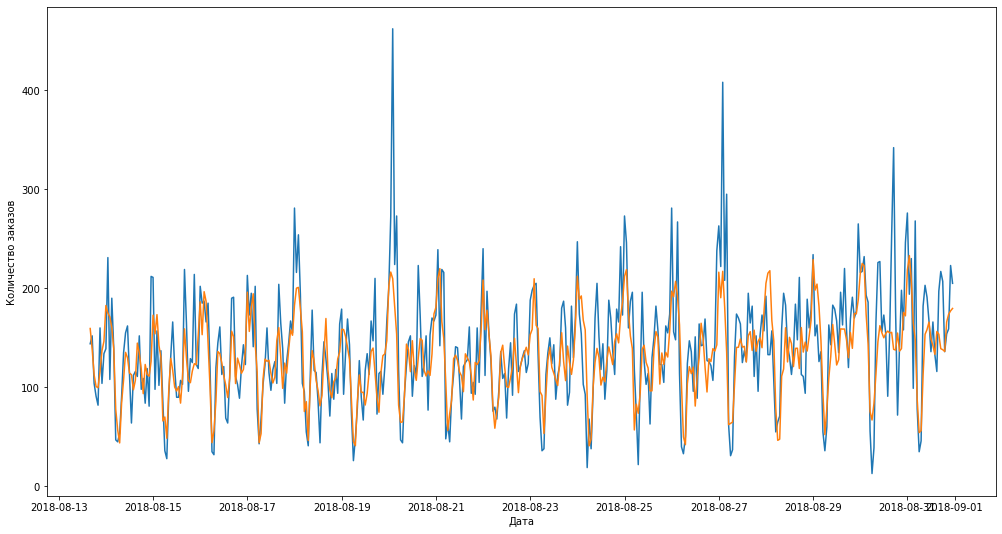

In [29]:
predictions_test = pd.Series(target_predict, index=target_test.index)
plt.figure(figsize=(17,9))
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.plot(target_test, label='Исходная выборка')
plt.plot(predictions_test, label='Предсказания')
plt.show()

__Вывод:__ Результат rmse на тестовой выборке - 40.78 - допустимый результат. На графике видно в целом соответствие предсказаний реальной ситуации, однако наличие значительных ошибок в пиковые зоны.

## Общий вывод

Были получены данные по заказам такси за весенне-летний период 2018 года. Была проведена обработка данных - проверка на наличие пропусков, монотонность. Данные были ресемплированы по часу для удобства исследования.

Были проанализированы графики временных рядов как по всем данным в целом, так и по месяцу и по несколким дням. Выявился тренд на увеличение количества заказов, также проявились ежесуточные максимумы и минимумы заказов на 12 часов ночи и 6 утра соответсвенно. 

Для моделирования были дополнительно созданы календарные признаки месяца, дня и дня недели. Были удалены пропуски и получена таблица, готовая для обучения моделей.

После разделения на обучающую и тестовую выборки, были обучены модели линейной регрессии, решающего дерева, случайного леса и LightGBM. Наилучшее значение метрики RMSE оказалось у LightGBM

Протестировав модель на тестовых данных, было получено значение RMSE 40.78.